In [4]:
import wfdb
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical

record_list = ["100", "101", "102", "103", "104", "105", "106", "107", "108", "109",
               "111", "112", "113", "114", "115", "116", "117", "118", "119",
               "121", "122", "123", "124", "200", "201", "202", "203", "205", "207",
               "208", "209", "210", "212", "213", "214", "215", "217", "219",
               "220", "221", "222", "223", "228", "230", "231", "232", "233", "234"]

def load_mitbih_data(record_list, window_size=100):
    X, y = [], []
    label_map = {"N": "Normal", "V": "PVC", "A": "APC", "L": "LBBB", "R": "RBBB"}

    for record in record_list:
        record_data = wfdb.rdsamp(f"mit_data/mit-bih-arrhythmia-database-1.0.0/{record}")
        annotations = wfdb.rdann(f"mit_data/mit-bih-arrhythmia-database-1.0.0/{record}", "atr")

        ecg_signal = record_data[0][:, 0]  # Lead I
        r_peaks = annotations.sample       # R-peak locations
        labels = annotations.symbol        # Arrhythmia labels

        scaler = StandardScaler()
        ecg_signal = scaler.fit_transform(ecg_signal.reshape(-1, 1)).flatten()

        # Extract beats
        for i, peak in enumerate(r_peaks):
            if peak - window_size//2 > 0 and peak + window_size//2 < len(ecg_signal):
                beat = ecg_signal[peak - window_size//2 : peak + window_size//2]
                if labels[i] in label_map:
                    X.append(beat)
                    y.append(label_map[labels[i]])

    return np.array(X), np.array(y)

X, y = load_mitbih_data(record_list)

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

X = X.reshape(X.shape[0], X.shape[1], 1)


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    x = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs  # Residual Connection

    x = Dense(ff_dim, activation="relu")(res)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    return x + res  # Residual Connection

def build_transformer(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128)
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs)
    return model

input_shape = (100, 1)  # Sequence Length = 100, Features = 1
num_classes = y_categorical.shape[1]
model = build_transformer(input_shape, num_classes)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()


W0000 00:00:1741188613.894557   27462 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 1)    │      1,793 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 100, 1)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 100, 1)    │          2 │ dropout_1[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 100, 1)    │          0 │ layer_normalizat… │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 100, 128)  │        256 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 100, 128)  │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 128)  │        256 │ dropout_2[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 100, 128)  │          0 │ layer_normalizat… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 128)  │    131,968 │ add_1[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 100, 128)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 128)  │        256 │ dropout_4[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 100, 128)  │          0 │ layer_normalizat… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 100, 128)  │     16,512 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 100, 128)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 128)  │        256 │ dropout_5[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 100, 128)  │          0 │ layer_normalizat… │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ add_3[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ global_average_p

 Total params: 159,880 (624.53 KB)

 Trainable params: 159,880 (624.53 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
2502/2502 ━━━━━━━━━━━━━━━━━━━━ 178s 68ms/step - accuracy: 0.8139 - loss: 0.5983 - val_accuracy: 0.8866 - val_loss: 0.3741
Epoch 2/20
2502/2502 ━━━━━━━━━━━━━━━━━━━━ 168s 67ms/step - accuracy: 0.8833 - loss: 0.3837 - val_accuracy: 0.9045 - val_loss: 0.3221
Epoch 3/20
2502/2502 ━━━━━━━━━━━━━━━━━━━━ 168s 67ms/step - accuracy: 0.8970 - loss: 0.3458 - val_accuracy: 0.9117 - val_loss: 0.2893
Epoch 4/20
2502/2502 ━━━━━━━━━━━━━━━━━━━━ 171s 69ms/step - accuracy: 0.9022 - loss: 0.3276 - val_accuracy: 0.9172 - val_loss: 0.2874
Epoch 5/20
2502/2502 ━━━━━━━━━━━━━━━━━━━━ 173s 69ms/step - accuracy: 0.9095 - loss: 0.3020 - val_accuracy: 0.9158 - val_loss: 0.3001
Epoch 6/20
2502/2502 ━━━━━━━━━━━━━━━━━━━━ 170s 68ms/step - accuracy: 0.9118 - loss: 0.2988 - val_accuracy: 0.9218 - val_loss: 0.2800
Epoch 7/20
2502/2502 ━━━━━━━━━━━━━━━━━━━━ 172s 69ms/step - accuracy: 0.9136 - loss: 0.2914 - val_accuracy: 0.9161 - val_loss: 0.2952
Epoch 8/20
2502/2502 ━━━━━━━━━━━━━━━━━━━━ 169s 67ms/step - accuracy: 

626/626 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.9427 - loss: 0.2146
Test Accuracy: 94.17%


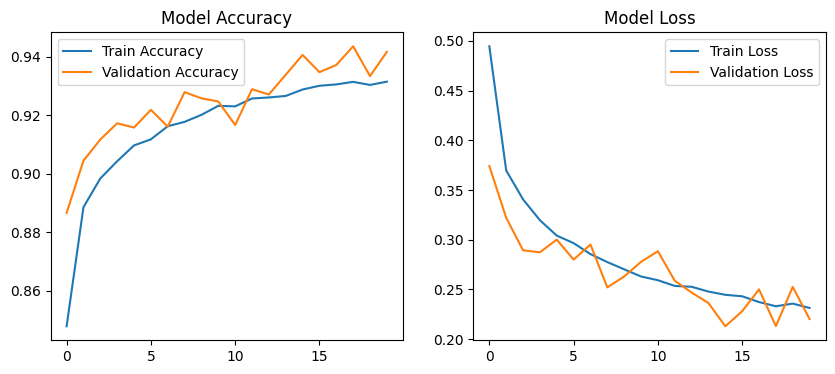

In [7]:
# Evaluate Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Model Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Model Loss")
plt.show()


In [8]:
model.save("ecg_transformer_model.keras")

In [1]:
from tensorflow.keras.models import load_model

model = load_model("ecg_transformer_model.keras")

2025-03-28 21:25:24.026873: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743177324.082795    6878 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743177324.100215    6878 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-28 21:25:24.218542: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
W0000 00:00:1743177331.599451    6878 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libr

In [2]:
import firebase_admin
from firebase_admin import credentials, db
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load Firebase credentials
cred = credentials.Certificate("rt-ecg-12-firebase-adminsdk-fbsvc-a2f427dc4d.json")  # Replace with actual JSON filename
firebase_admin.initialize_app(cred, {
    'databaseURL': 'https://rt-ecg-12-default-rtdb.asia-southeast1.firebasedatabase.app/'  # Replace with your Firebase DB URL
})


In [8]:
import pandas as pd

ref = db.reference("/")


In [11]:
ref.delete()

In [13]:
predictions = model.predict(X_input)
print("Model Prediction:", predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Model Prediction: [[8.8079162e-07 4.0058186e-11 9.9456847e-01 5.4307259e-03 2.1586363e-08]]


In [14]:
cl=["Normal","Premature ventricular contractions","Premature Atrial contractions","Left Bundle Branch block defects","Right Bundle Branch block defects"]
predicted_class = np.argmax(predictions, axis=1)
print(cl[predicted_class[0]])

Normal


In [18]:
import matplotlib.pyplot as plt

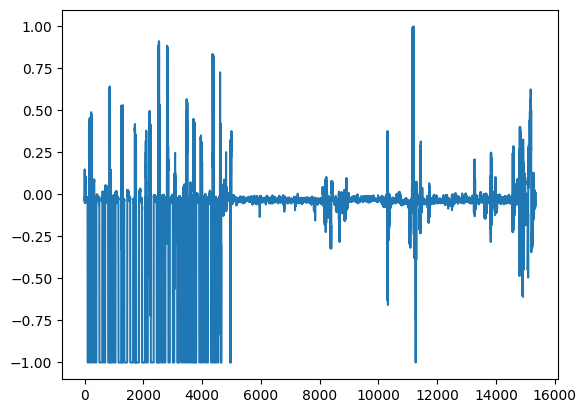

In [19]:
plt.plot(X)

71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step


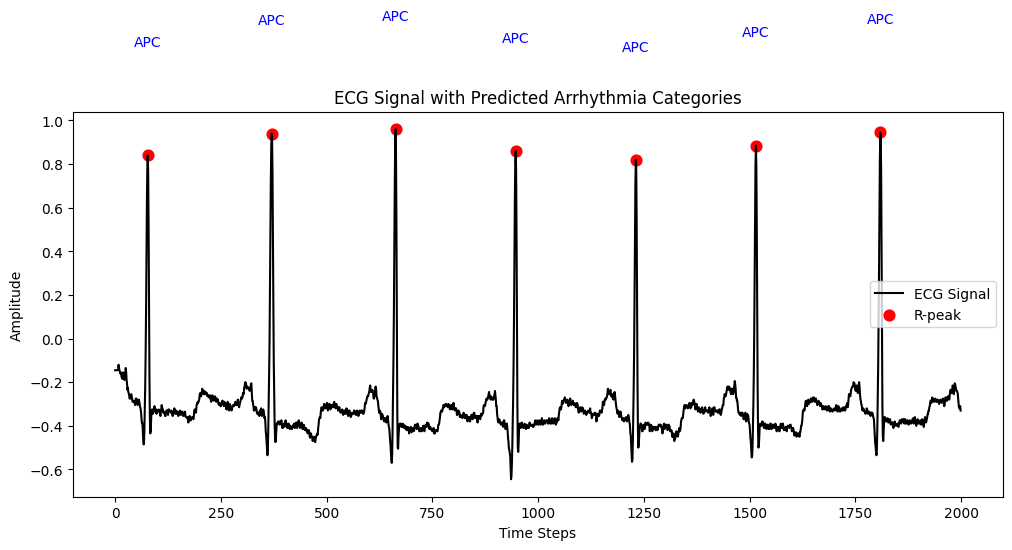

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder

# Load pre-trained model
model = load_model("ecg_transformer_model.keras")

def detect_r_peaks(ecg_signal, sampling_rate=360):
    """
    Improved R-peak detection using adaptive thresholding and prominence filtering.
    """
    peaks, _ = find_peaks(
        ecg_signal,
        height=np.mean(ecg_signal) + np.std(ecg_signal),  # Adaptive height
        distance=sampling_rate // 2,
        prominence=0.8 
    )
    return peaks

def load_csv_for_prediction(csv_path, window_size=100):
    df = pd.read_csv(csv_path)

    ecg_data = df["MLII"].values  # Extract ECG Lead II data

    scaler = StandardScaler()
    ecg_data = scaler.fit_transform(ecg_data.reshape(-1, 1)).flatten()

    # Detect R-peaks
    r_peaks = detect_r_peaks(ecg_data)

    X = []
    peak_indices = []
    for peak in r_peaks:
        if peak - window_size // 2 > 0 and peak + window_size // 2 < len(ecg_data):
            X.append(ecg_data[peak - window_size // 2 : peak + window_size // 2])
            peak_indices.append(peak)  # Store R-peak locations

    X = np.array(X).reshape(len(X), window_size, 1)

    return X, df, r_peaks, peak_indices

# Load ECG data
csv_file = "100.csv"
X_test, df_raw, r_peaks, peak_indices = load_csv_for_prediction(csv_file)

# Make predictions
y_pred_probs = model.predict(X_test)

# Get class labels
final_class_indices = np.argmax(y_pred_probs, axis=1)

# Define label encoder
encoder = LabelEncoder()
encoder.classes_ = np.array(["Normal", "PVC", "APC", "LBBB", "RBBB"])

# Convert indices to category names
predicted_labels = encoder.inverse_transform(final_class_indices)

# Plot ECG with detected R-peaks and predicted labels
def plot_ecg_with_labels(df, r_peaks, predicted_labels, num_samples=2000):
    plt.figure(figsize=(12, 5))
    plt.plot(df["MLII"].values[:num_samples], label="ECG Signal", color="black")

    for i, peak in enumerate(r_peaks):
        if peak < num_samples:  # Only plot peaks within range
            plt.scatter(peak, df["MLII"].values[peak], color="red", s=60, label="R-peak" if i == 0 else "")
            plt.text(peak, df["MLII"].values[peak] + 0.5, predicted_labels[i], color="blue", fontsize=10, ha="center")

    plt.title("ECG Signal with Predicted Arrhythmia Categories")
    plt.xlabel("Time Steps")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

# Display results
plot_ecg_with_labels(df_raw, peak_indices, predicted_labels, num_samples=2000)


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step 


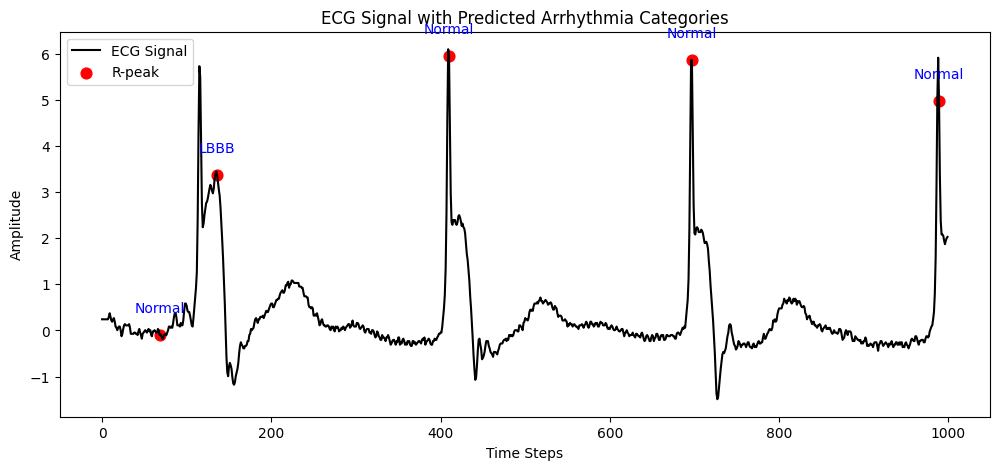

In [33]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder

# Load trained Transformer-based ECG model
model = load_model("ecg_transformer_model.keras")

# Load a record from the MIT-BIH Arrhythmia Database
record_name = "102"
record_path = f"mit_data/mit-bih-arrhythmia-database-1.0.0/{record_name}"

# Load ECG signal and annotations
record = wfdb.rdsamp(record_path)
annotations = wfdb.rdann(record_path, "atr")

# Extract ECG signal (Lead II)
ecg_signal = record[0][:, 0]

# Get R-peak locations from annotations
r_peaks = annotations.sample

# Normalize ECG Signal
scaler = StandardScaler()
ecg_signal = scaler.fit_transform(ecg_signal.reshape(-1, 1)).flatten()

# Set window size (should match model input)
window_size = 100  
X_input = []
peak_indices = []

# Extract beats centered around R-peaks
for peak in r_peaks:
    if peak - window_size//2 > 0 and peak + window_size//2 < len(ecg_signal):
        beat = ecg_signal[peak - window_size//2 : peak + window_size//2]
        X_input.append(beat)
        peak_indices.append(peak)  # Store R-peak locations

# Convert to NumPy array & Reshape for Model
X_input = np.array(X_input).reshape(len(X_input), window_size, 1)  

# Make predictions using the trained model
y_pred_probs = model.predict(X_input)

# Get predicted class indices
predicted_indices = np.argmax(y_pred_probs, axis=1)

# Label encoder for arrhythmia categories
encoder = LabelEncoder()
encoder.classes_ = np.array(["APC", "PVC","Normal", "LBBB", "RBBB"])

# Convert indices to actual category names
predicted_labels = encoder.inverse_transform(predicted_indices)

# Function to plot ECG with R-peaks and predicted labels
def plot_ecg_with_labels(ecg_signal, r_peaks, predicted_labels, num_samples=1000):
    plt.figure(figsize=(12, 5))
    plt.plot(ecg_signal[:num_samples], label="ECG Signal", color="black")

    for i, peak in enumerate(r_peaks):
        if peak < num_samples:  # Plot only within the range
            plt.scatter(peak, ecg_signal[peak], color="red", s=60, label="R-peak" if i == 0 else "")
            plt.text(peak, ecg_signal[peak] + 0.5, predicted_labels[i], color="blue", fontsize=10, ha="center")

    plt.title("ECG Signal with Predicted Arrhythmia Categories")
    plt.xlabel("Time Steps")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

# Display the ECG signal with labeled R-peaks
plot_ecg_with_labels(ecg_signal, peak_indices, predicted_labels, num_samples=1000)


In [34]:
# Load Transformer model
import tensorflow as tf

model = tf.keras.models.load_model("ecg_transformer_model.keras")

# Make Predictions
predictions = model.predict(X_input)

# Convert Predictions to Class Labels
predicted_classes = np.argmax(predictions, axis=1)

# Print Results
print("Predicted Classes:", predicted_classes)


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step 
Predicted Classes: [2 3 2 ... 2 2 2]
